# Project - Amazon_jobs_data

---

### 0. Import

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb

### 1. Data Setting

In [2]:
def jobs_data_setting():
    
    #Data road
    jobs_df = pd.read_csv("amazon_jobs_dataset.csv")
    
    #결측값 row 제거
    jobs_df = jobs_df.dropna()
    
    #직업 종류 추출
    cat = []
    for idx, con in enumerate(jobs_df['Title'].unique()):
        cat.append(con)
        
    #직업 종류 DataFrame
    cats = pd.DataFrame(cat , columns=["job"])
    
    #직업 종류 category number columns 생성
    cats['category'] = cats.index + 1
    
    #직업 종류 category number와 기존 직업 종류 merge
    A_jobs_df = pd.merge(jobs_df, cats, left_on="Title", right_on="job", how='left')
    
    #기존 직업 종류 columns drop
    A_jobs_df = A_jobs_df.drop('Title', axis=1)
    
    #전체 1555종류 직업중 3개의 직업이 26%((695+122+114)/3484) 차지 추출 진행, 
    #나머지는 1직업당 1개종류 차지하여 제거 진행 (ex)분석 자료 부족 + 직무의 모호성)
    A_jobs_df = A_jobs_df[A_jobs_df['category'].isin(['2','1','95'])]
    
    #분석에 필요없는 columns drop
    A_jobs_df = A_jobs_df.drop(["Unnamed: 0", 'location', 'Posting_date'], axis=1)
    
    #index reset
    A_jobs_df = A_jobs_df.reset_index(drop=True)
    
    return A_jobs_df

A_jobs_df = jobs_data_setting()

---

### 2. Plot

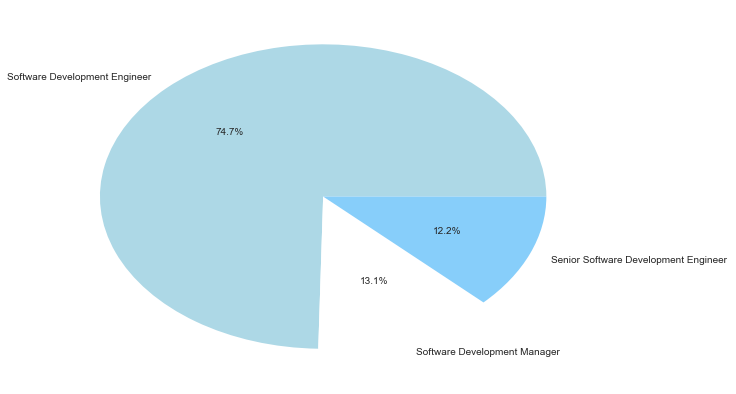

In [3]:
jobs_plot = A_jobs_df['job'].value_counts()
fig = plt.figure(figsize = (10,7))
labels = ['Software Development Engineer','Software Development Manager ','Senior Software Development Engineer ']
colors = ['lightblue', 'white', 'lightskyblue']
plt.pie(jobs_plot, labels=labels, colors=colors, autopct='%1.1f%%')
plt.show()

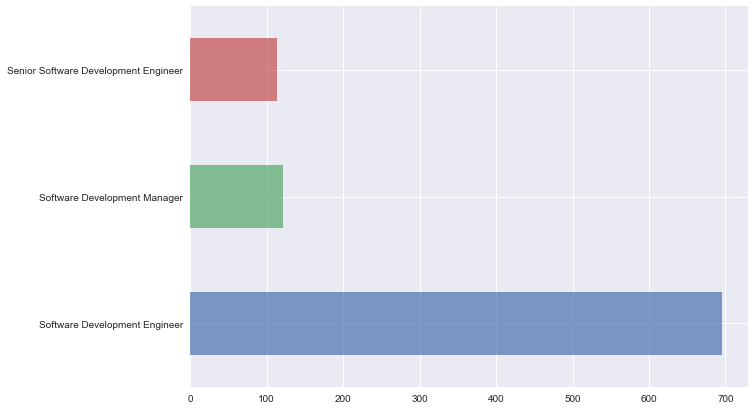

In [4]:
jobs_plot = A_jobs_df['job'].value_counts()
fig = plt.figure(figsize = (10,7))
jobs_plot.plot(kind="barh", align='center', alpha=0.7)
plt.show()

---

### 3. Data Split

In [5]:
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(A_jobs_df['DESCRIPTION'], A_jobs_df.category, \
                                                    test_size=0.2, random_state=0)

len(X_train_D),len(X_test_D),len(y_train_D),len(y_test_D)

(744, 187, 744, 187)

In [6]:
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(A_jobs_df['BASIC QUALIFICATIONS'], A_jobs_df.category, \
                                                    test_size=0.2, random_state=0)

len(X_train_B),len(X_test_B),len(y_train_B),len(y_test_B)

(744, 187, 744, 187)

In [7]:
X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(A_jobs_df['PREFERRED QUALIFICATIONS'], A_jobs_df.category, \
                                                    test_size=0.2, random_state=0)

len(X_train_P),len(X_test_P),len(y_train_P),len(y_test_P)

(744, 187, 744, 187)

---

### 4. Tokenize + Pipeline

In [8]:
from konlpy.tag import Twitter
pos_tagger = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]

In [51]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,3), \
                             stop_words=["is", "the", "this", "-", ".", "·", "There", "&", "are", "a"])), 
    ("clf", MultinomialNB(alpha=0.05))
])

---

### 5-1. Model Fit & Check (DESCRIPTION)

In [36]:
def DESCRIPTION_Fit():
    model_D = clf.fit(X_train_D, y_train_D)
    
    y_pred_D = model_D.predict(X_train_D)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_D, y_pred_D), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_D, y_pred_D), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_D, y_pred_D), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_D_T = model_D.predict(X_test_D)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_D, y_pred_D_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_D, y_pred_D_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_D, y_pred_D_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_D, y_pred_D), accuracy_score(y_test_D, y_pred_D_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[ 96   8   0]
 [  6 534  10]
 [  0  27  63]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.94      0.92      0.93       104
          2       0.94      0.97      0.95       550
         95       0.86      0.70      0.77        90

avg / total       0.93      0.93      0.93       744
 


Train accuracy_score 

0.93 




Test 

Test confusion_matrix 

[[  8  10   0]
 [  3 132  10]
 [  3  17   4]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.57      0.44      0.50        18
          2       0.83      0.91      0.87       145
         95       0.29      0.17      0.21        24

avg / total       0.74      0.77      0.75       187
 


Test accuracy_score 

0.77 




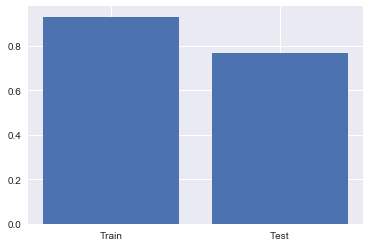

In [37]:
DESCRIPTION_Fit()

---

### 5-2. Model Fit & Check (BASIC QUALIFICATIONS)

In [14]:
def BASIC_QUALIFICATIONS_Fit():
    model_B = clf.fit(X_train_B, y_train_B)
    
    y_pred_B = model_B.predict(X_train_B)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_B, y_pred_B), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_B, y_pred_B), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_B, y_pred_B), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_B_T = model_B.predict(X_test_B)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_B, y_pred_B_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_B, y_pred_B_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_B, y_pred_B_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_B, y_pred_B), accuracy_score(y_test_B, y_pred_B_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[102   2   0]
 [  7 525  18]
 [  1  22  67]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.93      0.98      0.95       104
          2       0.96      0.95      0.96       550
         95       0.79      0.74      0.77        90

avg / total       0.93      0.93      0.93       744
 


Train accuracy_score 

0.93 




Test 

Test confusion_matrix 

[[ 13   5   0]
 [  4 129  12]
 [  2  15   7]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.68      0.72      0.70        18
          2       0.87      0.89      0.88       145
         95       0.37      0.29      0.33        24

avg / total       0.78      0.80      0.79       187
 


Test accuracy_score 

0.8 




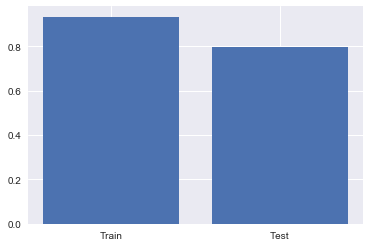

In [15]:
BASIC_QUALIFICATIONS_Fit()

---

### 5-3. Model Fit & Check (PREFERRED QUALIFICATIONS)

In [16]:
def PREFERRED_QUALIFICATIONS_Fit():
    model_P = clf.fit(X_train_P, y_train_P)
    
    y_pred_P = model_P.predict(X_train_P)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_P, y_pred_P), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_P, y_pred_P), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_P, y_pred_P), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_P_T = model_P.predict(X_test_P)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_P, y_pred_P_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_P, y_pred_P_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_P, y_pred_P_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_P, y_pred_P), accuracy_score(y_test_P, y_pred_P_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[101   3   0]
 [ 15 523  12]
 [  3  20  67]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.85      0.97      0.91       104
          2       0.96      0.95      0.95       550
         95       0.85      0.74      0.79        90

avg / total       0.93      0.93      0.93       744
 


Train accuracy_score 

0.93 




Test 

Test confusion_matrix 

[[  7  11   0]
 [  7 128  10]
 [  2  15   7]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.44      0.39      0.41        18
          2       0.83      0.88      0.86       145
         95       0.41      0.29      0.34        24

avg / total       0.74      0.76      0.75       187
 


Test accuracy_score 

0.76 




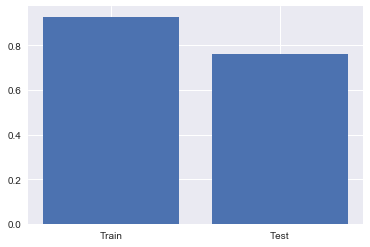

In [17]:
PREFERRED_QUALIFICATIONS_Fit()

---

### 5-4. Con_Model Fit & Check (Total)

In [52]:
def con_data_setting_split():
    A_jobs_df_D = A_jobs_df.drop(['BASIC QUALIFICATIONS','PREFERRED QUALIFICATIONS'],axis=1)
    A_jobs_df_D = A_jobs_df_D.rename(columns={'DESCRIPTION':'con'})

    A_jobs_df_B = A_jobs_df.drop(['DESCRIPTION','PREFERRED QUALIFICATIONS'],axis=1)
    A_jobs_df_B = A_jobs_df_B.rename(columns={'BASIC QUALIFICATIONS':'con'})

    A_jobs_df_P = A_jobs_df.drop(['BASIC QUALIFICATIONS','DESCRIPTION'],axis=1)
    A_jobs_df_P = A_jobs_df_P.rename(columns={'PREFERRED QUALIFICATIONS':'con'})

    A_jobs_df_con = pd.concat([A_jobs_df_D,A_jobs_df_B,A_jobs_df_P],axis=0)
    
    A_jobs_df_con = A_jobs_df_con.reset_index(drop=True)
    
    return A_jobs_df_con

A_jobs_df_con = con_data_setting_split()

In [53]:
con_data_setting_split().tail()

,con,job,category
2788,· Excellent design skills with a proven abilit...,Software Development Engineer,2
2789,"· Experience in leading engineering team, coac...",Software Development Manager,1
2790,"· MS in Computer Science, Computer/Electrical ...",Software Development Engineer,2
2791,· Computer Science fundamentals in algorithm d...,Software Development Engineer,2
2792,* Experience building complex software systems...,Software Development Engineer,2


In [54]:
X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(A_jobs_df_con['con'], A_jobs_df_con['category'], \
                                                test_size=0.2, random_state=0)

len(X_train_con),len(X_test_con),len(y_train_con),len(y_test_con)

(2234, 559, 2234, 559)

In [55]:
def Con_Fit():
    model_con = clf.fit(X_train_con, y_train_con)
    
    y_pred_con = model_con.predict(X_train_con)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_con, y_pred_con), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_con, y_pred_con), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_con, y_pred_con), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_con_T = model_con.predict(X_test_con)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_con, y_pred_con_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_con, y_pred_con_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_con, y_pred_con_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_con, y_pred_con), accuracy_score(y_test_con, y_pred_con_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[ 258   37    0]
 [  15 1618   25]
 [   4  119  158]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.93      0.87      0.90       295
          2       0.91      0.98      0.94      1658
         95       0.86      0.56      0.68       281

avg / total       0.91      0.91      0.90      2234
 


Train accuracy_score 

0.91 




Test 

Test confusion_matrix 

[[ 36  35   0]
 [ 13 400  14]
 [  0  50  11]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.73      0.51      0.60        71
          2       0.82      0.94      0.88       427
         95       0.44      0.18      0.26        61

avg / total       0.77      0.80      0.77       559
 


Test accuracy_score 

0.8 




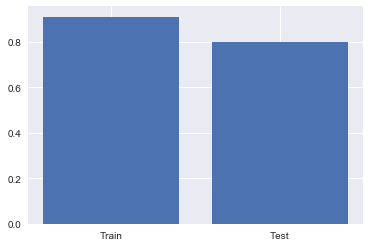

In [56]:
Con_Fit()

---

### 6-1. CountVectorizer (DESCRIPTION)

In [57]:
def CountVectorizer_DESCRIPTION():
    vect = CountVectorizer()
    vect.fit(A_jobs_df['DESCRIPTION'])
    #vect.vocabulary_
    
    check_D = vect.transform(A_jobs_df['DESCRIPTION']).toarray()
    
    check_D = pd.DataFrame(check_D)
    
    check_D['y'] = A_jobs_df['category']
    
    return check_D

check_D = CountVectorizer_DESCRIPTION()

In [58]:
check_D.tail()

,0,1,2,3,4,5,6,7,8,9,...,5745,5746,5747,5748,5749,5750,5751,5752,5753,y
926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
928,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [88]:
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(check_D, check_D['y'], \
                                                    test_size=0.2, random_state=0)

len(X_train_CD),len(X_test_CD),len(y_train_CD),len(y_test_CD)

(744, 187, 744, 187)

### 6-1-1. LGBMClassifier_cross_val_score (DESCRIPTION)

In [79]:
le = LabelEncoder()

y_train = le.fit_transform(check_D['y'])
X_train = check_D.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Start1
log_loss: -0.64 (0.15) -> None
End
 
Start2
log_loss: -0.53 (0.11) -> reg_alpha=0.5
End
 
Start3
log_loss: -0.51 (0.11) -> reg_alpha=1
End
 
Start4
log_loss: -0.48 (0.08) -> reg_alpha=0.5, l_r=0.05, n_estimator=200
End
 
Start5
log_loss: -0.48 (0.08) -> reg_alpha=1, l_r=0.05, n_estimator=300
End
 
Trial_Error
log_loss: -0.97 (0.30) -> n_estimator=200
End
 


### 6-1-2. LGBMClassifier_Fit & Check (DESCRIPTION)

In [89]:
def CountVectorizer_DESCRIPTION_Fit():
    
    model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
    model_lgb.fit(X_train_CD, y_train_CD)
    
    y_pred_l = model_lgb.predict(X_train_CD)
    
    print("Train", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_train_CD, y_pred_l), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_train_CD, y_pred_l), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_train_CD, y_pred_l),2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_l_T = model_lgb.predict(X_test_CD)
    
    print("Test", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_test_CD, y_pred_l_T), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_test_CD, y_pred_l_T), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_test_CD, y_pred_l_T),2))
    
    x="Train","Test"
    y=accuracy_score(y_train_CD, y_pred_l), accuracy_score(y_test_CD, y_pred_l_T)
    plt.bar(x,y)
    plt.show()

Train 

Confusion_Matrix 

[[104   0   0]
 [  0 550   0]
 [  0   0  90]] 


Classification_Report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       104
          2       1.00      1.00      1.00       550
         95       1.00      1.00      1.00        90

avg / total       1.00      1.00      1.00       744
 


Accuracy_Score 

1.0 




Test 

Confusion_Matrix 

[[ 18   0   0]
 [  0 145   0]
 [  0   0  24]] 


Classification_Report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        18
          2       1.00      1.00      1.00       145
         95       1.00      1.00      1.00        24

avg / total       1.00      1.00      1.00       187
 


Accuracy_Score 

1.0


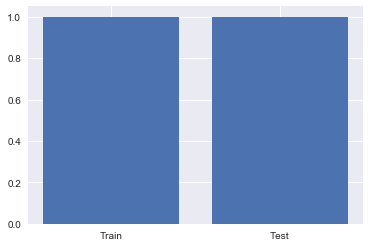

In [90]:
CountVectorizer_DESCRIPTION_Fit()

---

### 6-2. CountVectorizer (BASIC QUALIFICATIONS)

In [66]:
def CountVectorizer_BASIC_QUALIFICATIONS():
    vect = CountVectorizer()
    vect.fit(A_jobs_df['BASIC QUALIFICATIONS'])
    #vect.vocabulary_
    
    check_BQ = vect.transform(A_jobs_df['BASIC QUALIFICATIONS']).toarray()
    
    check_BQ = pd.DataFrame(check_BQ)
    
    check_BQ['y'] = A_jobs_df['category']
    
    return check_BQ

check_BQ = CountVectorizer_BASIC_QUALIFICATIONS()

In [67]:
check_BQ.tail()

,0,1,2,3,4,5,6,7,8,9,...,1714,1715,1716,1717,1718,1719,1720,1721,1722,y
926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,2
927,1,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
928,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,2
930,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,0,0,0,0,0,2


In [68]:
X_train_BD, X_test_BD, y_train_BD, y_test_BD = train_test_split(check_BQ, check_BQ['y'], \
                                                    test_size=0.2, random_state=0)

len(X_train_BD),len(X_test_BD),len(y_train_BD),len(y_test_BD)

(744, 187, 744, 187)

### 6-2-1. LGBMClassifier_cross_val_score (BASIC QUALIFICATIONS)

In [69]:
le = LabelEncoder()

y_train = le.fit_transform(check_BQ['y'])
X_train = check_BQ.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Start1
log_loss: -0.64 (0.14) -> None
End
 
Start2
log_loss: -0.55 (0.08) -> reg_alpha=0.5
End
 
Start3
log_loss: -0.53 (0.05) -> reg_alpha=1
End
 
Start4
log_loss: -0.51 (0.04) -> reg_alpha=0.5, l_r=0.05, n_estimator=200
End
 
Start5
log_loss: -0.51 (0.03) -> reg_alpha=1, l_r=0.05, n_estimator=300
End
 
Trial_Error
log_loss: -0.88 (0.29) -> n_estimator=200
End
 


### 6-2-2. LGBMClassifier_Fit & Check (BASIC QUALIFICATIONS)

In [70]:
def CountVectorizer_BASIC_QUALIFICATIONS_Fit():
    
    model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
    model_lgb.fit(X_train_BD, y_train_BD)
    
    y_pred_l = model_lgb.predict(X_train_BD)
    
    print("Train", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_train_BD, y_pred_l), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_train_BD, y_pred_l), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_train_BD, y_pred_l),2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_l_T = model_lgb.predict(X_test_BD)
    
    print("Test", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_test_BD, y_pred_l_T), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_test_BD, y_pred_l_T), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_test_BD, y_pred_l_T),2))
    
    x="Train","Test"
    y=accuracy_score(y_train_BD, y_pred_l), accuracy_score(y_test_BD, y_pred_l_T)
    plt.bar(x,y)
    plt.show()

Train 

Confusion_Matrix 

[[104   0   0]
 [  0 550   0]
 [  0   0  90]] 


Classification_Report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       104
          2       1.00      1.00      1.00       550
         95       1.00      1.00      1.00        90

avg / total       1.00      1.00      1.00       744
 


Accuracy_Score 

1.0 




Test 

Confusion_Matrix 

[[ 18   0   0]
 [  0 145   0]
 [  0   0  24]] 


Classification_Report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        18
          2       1.00      1.00      1.00       145
         95       1.00      1.00      1.00        24

avg / total       1.00      1.00      1.00       187
 


Accuracy_Score 

1.0


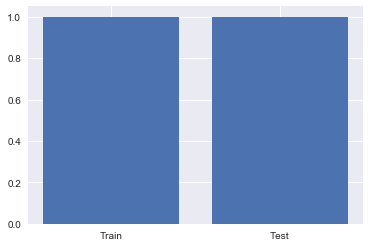

In [71]:
CountVectorizer_BASIC_QUALIFICATIONS_Fit()

---

### 6-3. CountVectorizer (PREFERRED QUALIFICATIONS)

In [72]:
def CountVectorizer_PREFERRED_QUALIFICATIONS():
    vect = CountVectorizer()
    vect.fit(A_jobs_df['PREFERRED QUALIFICATIONS'])
    #vect.vocabulary_
    
    check_PQ = vect.transform(A_jobs_df['PREFERRED QUALIFICATIONS']).toarray()
    
    check_PQ = pd.DataFrame(check_PQ)
    
    check_PQ['y'] = A_jobs_df['category']
    
    return check_PQ

check_PQ = CountVectorizer_PREFERRED_QUALIFICATIONS()

In [73]:
check_PQ.tail()

,0,1,2,3,4,5,6,7,8,9,...,2454,2455,2456,2457,2458,2459,2460,2461,2462,y
926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
928,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [74]:
X_train_PD, X_test_PD, y_train_PD, y_test_PD = train_test_split(check_PQ, check_PQ['y'], \
                                                    test_size=0.2, random_state=0)

len(X_train_PD),len(X_test_PD),len(y_train_PD),len(y_test_PD)

(744, 187, 744, 187)

### 6-3-1. LGBMClassifier_cross_val_score (PREFERRED QUALIFICATIONS)

In [75]:
le = LabelEncoder()

y_train = le.fit_transform(check_PQ['y'])
X_train = check_PQ.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Start1
log_loss: -0.78 (0.14) -> None
End
 
Start2
log_loss: -0.70 (0.12) -> reg_alpha=0.5
End
 
Start3
log_loss: -0.68 (0.10) -> reg_alpha=1
End
 
Start4
log_loss: -0.66 (0.08) -> reg_alpha=0.5, l_r=0.05, n_estimator=200
End
 
Start5
log_loss: -0.66 (0.07) -> reg_alpha=1, l_r=0.05, n_estimator=300
End
 
Trial_Error
log_loss: -1.08 (0.22) -> n_estimator=200
End
 


### 6-3-2. LGBMClassifier_Fit & Check (PREFERRED QUALIFICATIONS)

In [76]:
def CountVectorizer_PREFERRED_QUALIFICATIONS_Fit():
    
    model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
    model_lgb.fit(X_train_PD, y_train_PD)
    
    y_pred_l = model_lgb.predict(X_train_PD)
    
    print("Train", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_train_PD, y_pred_l), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_train_PD, y_pred_l), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_train_PD, y_pred_l),2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_l_T = model_lgb.predict(X_test_PD)
    
    print("Test", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_test_PD, y_pred_l_T), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_test_PD, y_pred_l_T), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_test_PD, y_pred_l_T),2))
    
    x="Train","Test"
    y=accuracy_score(y_train_PD, y_pred_l), accuracy_score(y_test_PD, y_pred_l_T)
    plt.bar(x,y)
    plt.show()

Train 

Confusion_Matrix 

[[104   0   0]
 [  0 550   0]
 [  0   0  90]] 


Classification_Report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       104
          2       1.00      1.00      1.00       550
         95       1.00      1.00      1.00        90

avg / total       1.00      1.00      1.00       744
 


Accuracy_Score 

1.0 




Test 

Confusion_Matrix 

[[ 18   0   0]
 [  0 145   0]
 [  0   0  24]] 


Classification_Report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        18
          2       1.00      1.00      1.00       145
         95       1.00      1.00      1.00        24

avg / total       1.00      1.00      1.00       187
 


Accuracy_Score 

1.0


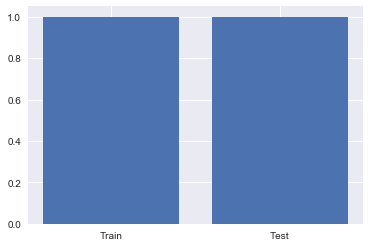

In [77]:
CountVectorizer_PREFERRED_QUALIFICATIONS_Fit()